Набор данных для анализа взят по следующей ссылке: https://www.kaggle.com/datasets/shubhankitsirvaiya06/diamond-price-prediction
Настоящий набор данных содержит информацию о том, как цена бриллиантов зависит от качественных и количественных характеристик: размер, цвет, караты, качество.


Для текущего набора данных целевой переменной объявим цену (price). Это численная переменная, соответственно, в качестве метрики качества целесообразно выбрать, например, MSE или RMSE. По среднеквадратичному отклонению будет удобно просматривать ошибку работы модели в предсказании цены.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(0)

In [2]:
initial_data = pd.read_csv('diamonds.csv')
print(initial_data.shape)
initial_data.head()

(53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Сразу отсечём тестовый набор данных, не будем просматривать его статистики.

In [3]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(initial_data, test_size=0.1)
df_train.shape

(48546, 10)

Посмотрим, есть ли пропуски в тренировочном наборе данных.

In [4]:
df_train.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Данные отличные, пропусков нет. Значит, перейдём к визуализации данных.

In [5]:
X_train, y_train = df_train.drop(columns='price'), df_train.price
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
37974,0.40,Good,G,VS2,63.8,59.0,4.64,4.57,2.94
45366,0.55,Ideal,E,VS2,61.5,57.0,5.25,5.29,3.24
34601,0.27,Very Good,E,VS1,60.4,59.0,4.18,4.20,2.53
32113,0.25,Ideal,E,VVS1,62.3,53.0,4.08,4.11,2.55
22778,1.01,Very Good,F,IF,59.2,60.0,6.48,6.59,3.87


In [6]:
X_test, y_test = df_test.drop(columns='price'), df_test.price
X_test.head()

,carat,cut,color,clarity,depth,table,x,y,z
10176,1.10,Ideal,H,SI2,62.0,55.0,6.61,6.65,4.11
16083,1.29,Ideal,H,SI1,62.6,56.0,6.96,6.93,4.35
13420,1.20,Premium,I,SI1,61.1,58.0,6.88,6.80,4.18
20407,1.50,Ideal,F,SI1,60.9,56.0,7.43,7.36,4.50
8909,0.90,Very Good,F,VS2,61.7,57.0,6.17,6.21,3.82


In [7]:
df_train.cut.value_counts().index

Index(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype='object', name='cut')

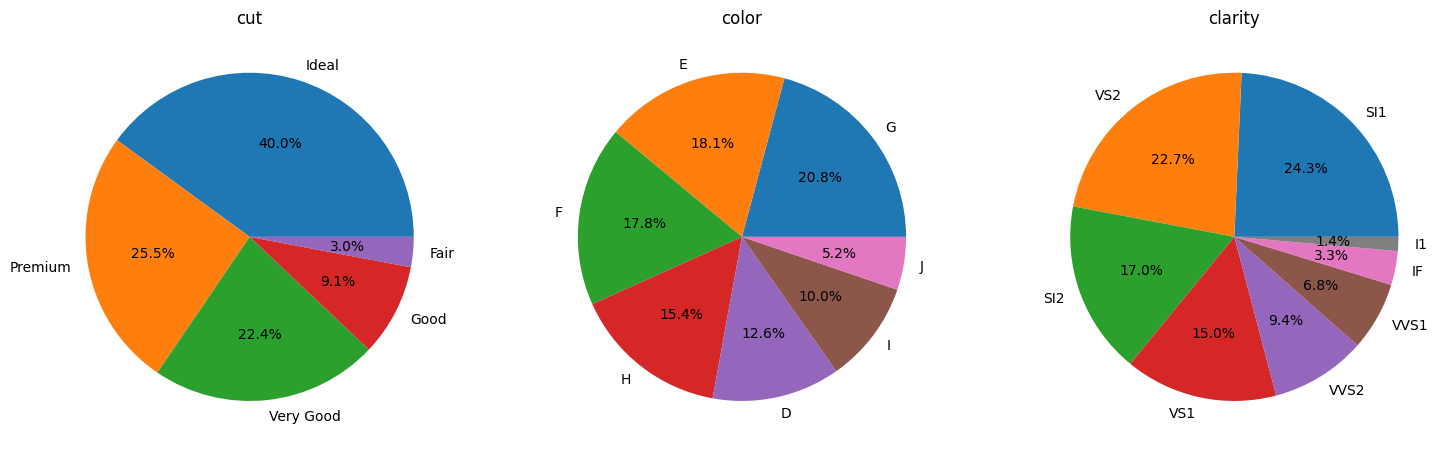

In [8]:
fig, ax = plt.subplots(1, X_train.select_dtypes(include='object').shape[1], figsize=(18, 6))

for idx, column in enumerate(X_train.select_dtypes(include='object').columns):
    curr_data = df_train[column].value_counts()
    ax[idx].pie(curr_data, labels=curr_data.index, autopct='%1.1f%%')
    ax[idx].title.set_text(column)
plt.show()

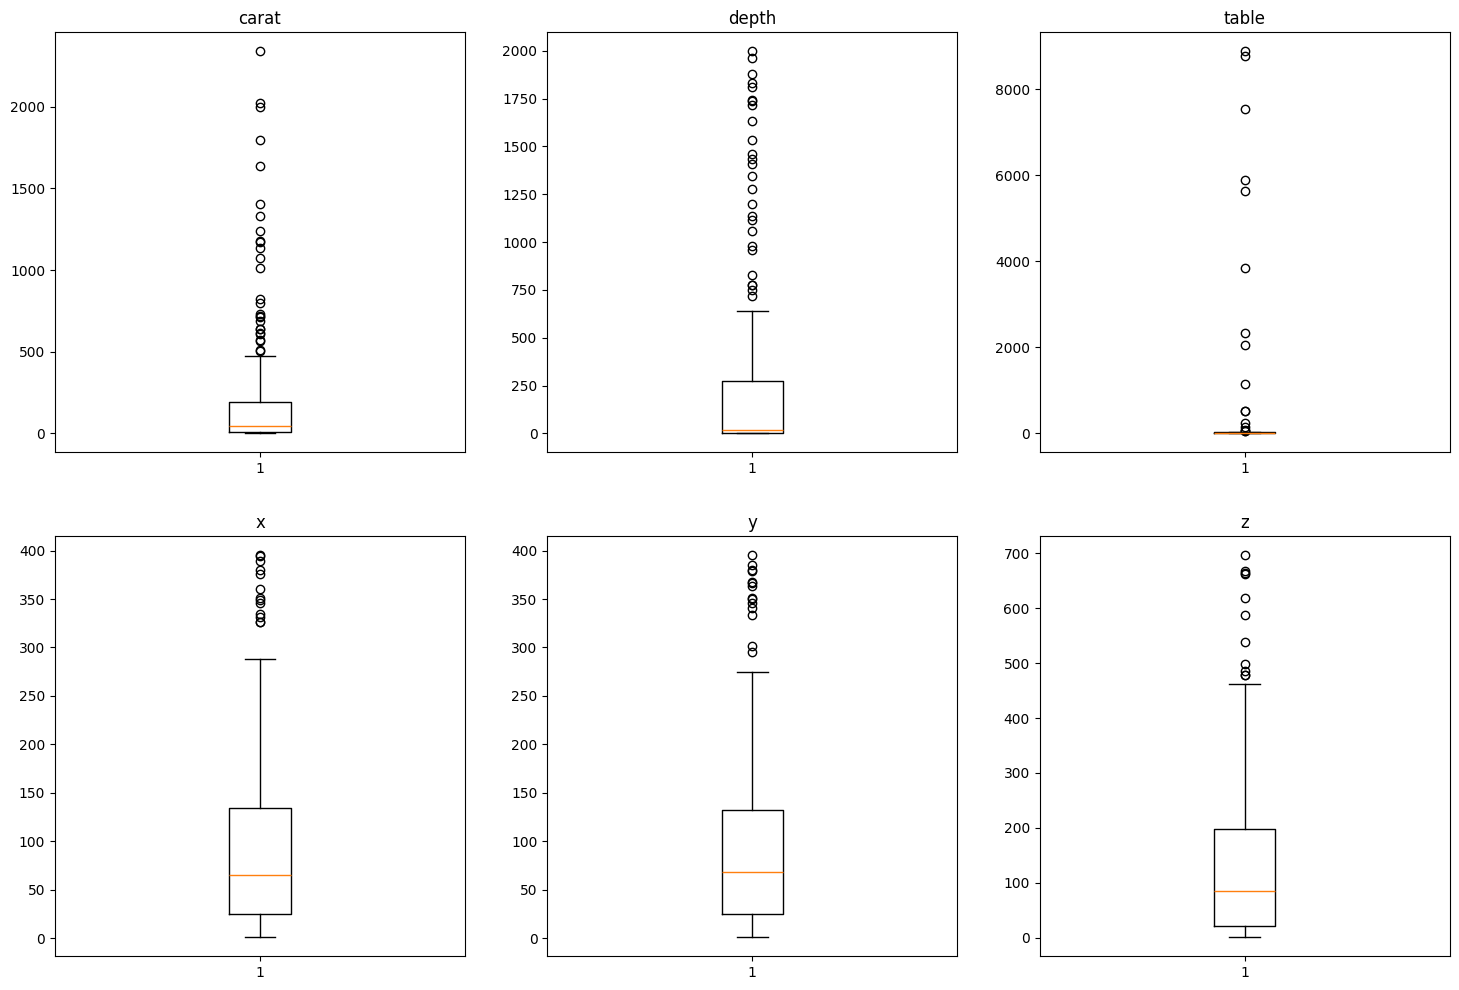

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

for idx, column in enumerate(X_train.select_dtypes(exclude='object').columns):
    curr_data = df_train[column].value_counts()
    ax[idx // 3, idx % 3].boxplot(curr_data)
    ax[idx // 3, idx % 3].title.set_text(column)
plt.show()

<Axes: >

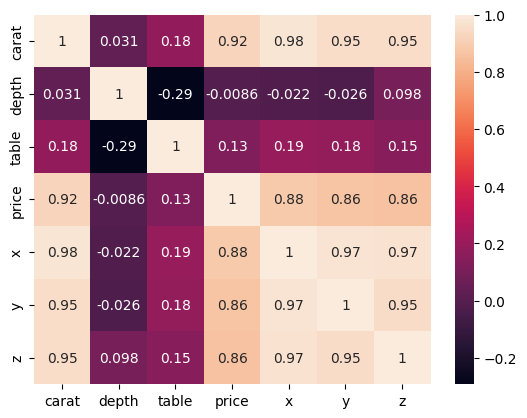

In [10]:
sns.heatmap(df_train.select_dtypes(exclude='object').corr(), annot=True)

Качество бриллиантов измеряется по колонке cut, поэтому представленные значения в колонках можно представить в виде численных значений (наихудшее качество - 0, наивысшее качество - наивысшая оценка). Перекодируем, таким образом, колонку cut.

In [11]:
def separate_num_cat(df: pd.DataFrame):
    ndf = df.copy()
    dct = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
    ndf['cut'] = ndf['cut'].replace(dct)
    ncat, nnum = ndf.select_dtypes(include='object'), ndf.select_dtypes(exclude='object')
    return ncat, nnum


X_train_cat, X_train_num = separate_num_cat(X_train)
X_test_cat, X_test_num = separate_num_cat(X_test)
X_train_cat

,color,clarity
37974,G,VS2
45366,E,VS2
34601,E,VS1
32113,E,VVS1
22778,F,IF
...,...,...
45891,F,VS2
52416,D,SI1
42613,I,VS1
43567,G,IF


In [12]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(drop='first')
cat_columns = X_train_cat.select_dtypes(include='object').columns
ohe.fit(X_train_cat)

def complete_dataframe(df_num: pd.DataFrame, df_cat: pd.DataFrame) -> pd.DataFrame:
    df_num, df_cat = df_num.copy(), df_cat.copy()
    new_cat_features = ohe.get_feature_names_out(cat_columns)
    df_cat = pd.DataFrame(ohe.transform(df_cat).toarray(), columns=new_cat_features)
    df_num = df_num.reset_index().drop(columns=['index'])
    return pd.merge(df_num, df_cat, left_index=True, right_index=True)

X_train_new = complete_dataframe(X_train_num, X_train_cat)
X_test_new = complete_dataframe(X_test_num, X_test_cat)

X_train_new.head()


,carat,cut,depth,table,x,y,z,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.40,1,63.8,59.0,4.64,4.57,2.94,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.55,4,61.5,57.0,5.25,5.29,3.24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.27,2,60.4,59.0,4.18,4.20,2.53,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.25,4,62.3,53.0,4.08,4.11,2.55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.01,2,59.2,60.0,6.48,6.59,3.87,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


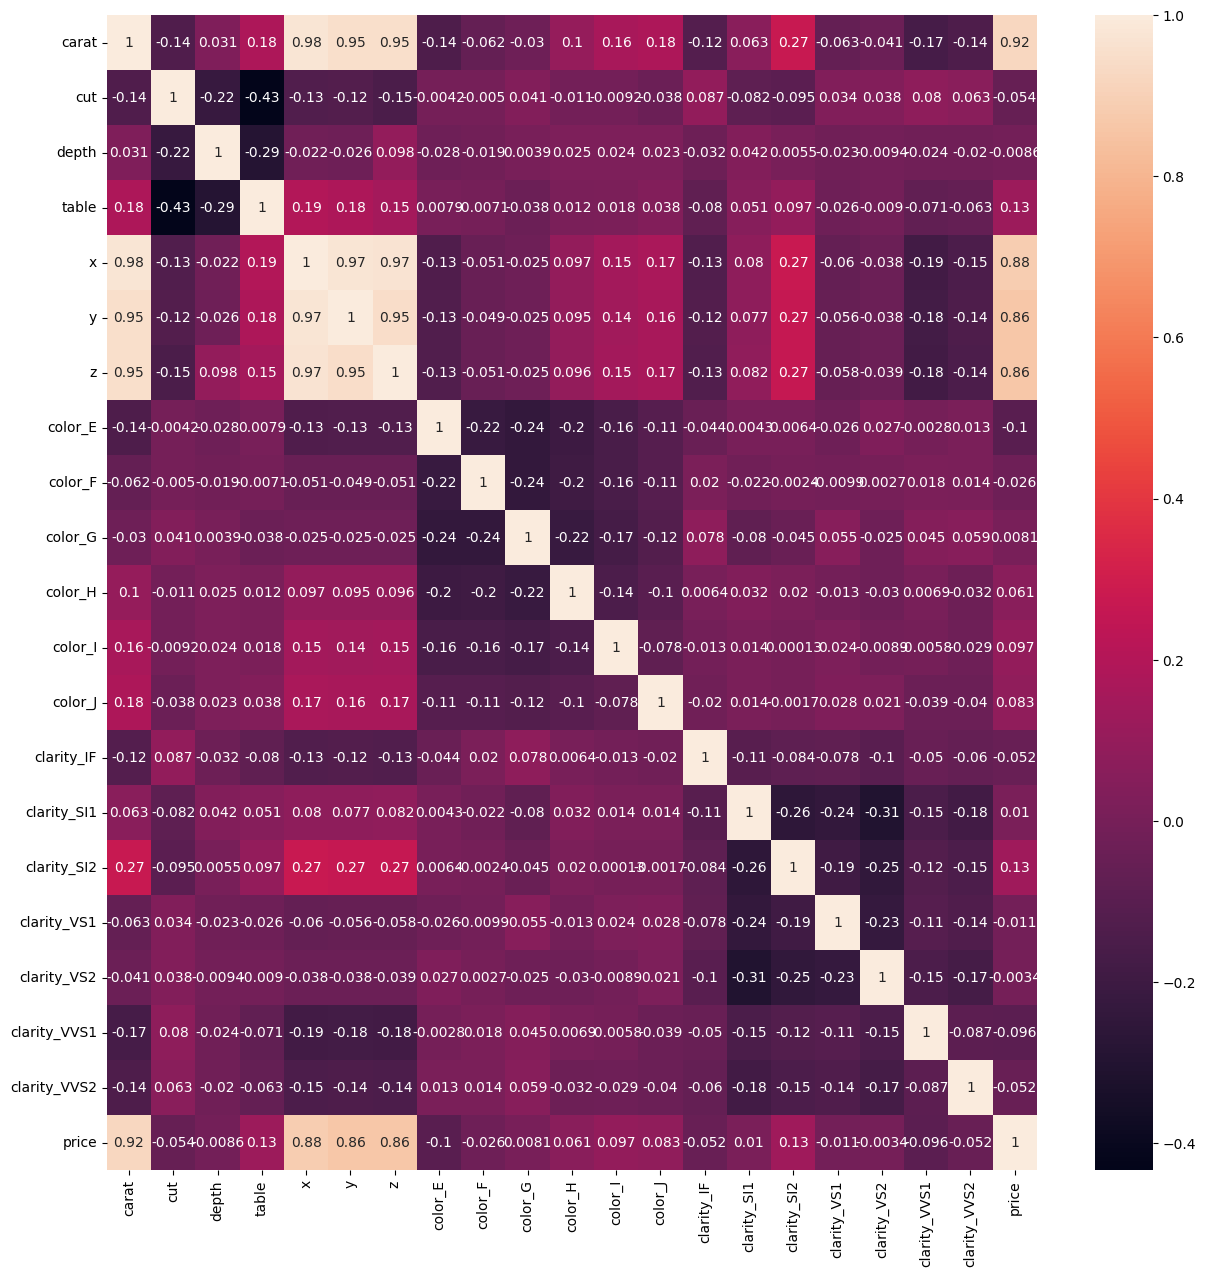

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.merge(X_train_new, y_train.reset_index().drop('index', axis=1), left_index=True, right_index=True).corr(), annot=True)
plt.show()

Из представленной таблицы видно, что цена в наибольшей мере коррелирует с размерами (x, y, z) и каратами (которые также сильно взаимосвязаны с размерами).

Представим последний график, на котором посмотрим на распределение целевой переменной тренировочного набора данных.

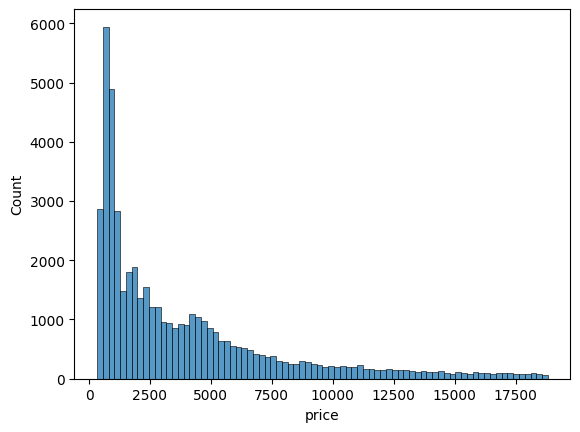

In [14]:
sns.histplot(data=y_train)
plt.show()

Количество "дешёвых" бриллиантов оказалось доминирующим, чего и следовало ожидать.
Перейдём к построению Baseline-модели.

In [15]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(X_train_new)


def scale_data(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(scaler.transform(df), columns=df.columns)


X_train_norm = scale_data(X_train_new)
X_test_norm = scale_data(X_test_new)
X_train_norm

,carat,cut,depth,table,x,y,z,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.041580,0.25,0.577778,0.444444,0.432030,0.077589,0.092453,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.072765,1.00,0.513889,0.388889,0.488827,0.089813,0.101887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.014553,0.50,0.483333,0.444444,0.389199,0.071307,0.079560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.010395,1.00,0.536111,0.277778,0.379888,0.069779,0.080189,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.168399,0.50,0.450000,0.472222,0.603352,0.111885,0.121698,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48541,0.066528,0.75,0.491667,0.444444,0.482309,0.087267,0.098428,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48542,0.103950,0.25,0.572222,0.472222,0.520484,0.093548,0.110377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
48543,0.024948,0.75,0.508333,0.416667,0.405028,0.074533,0.084277,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48544,0.043659,1.00,0.500000,0.388889,0.447858,0.081324,0.092138,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as MSE


lrm = LR()
# Разобьем тренировочные данные на тренировочные и валидационные.
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.2, random_state=42)

lrm.fit(X_train_train, y_train_train)


def RMSE(y_true, y_pred):
    return MSE(y_true, y_pred) ** 0.5

def show_result(model):
    mse_basic_train_result = RMSE(y_train_train, model.predict(X_train_train))
    print(f'Mean train price: {y_train_train.mean():.2f}, mean predicted price variation: {mse_basic_train_result:.2f}')
    print(f'Validation results: {RMSE(y_val, model.predict(X_val)):.2f}')
    print(f'Test result: {RMSE(y_test, lrm.predict(X_test_norm)):.2f}')

show_result(lrm)

Mean train price: 3930.69, mean predicted price variation: 27.25
Validation results: 27.03
Test result: 27.22
